In [ ]:
import numpy as np
import scipy 
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestCentroid
from math import sqrt
import sklearn as sk

In [ ]:
def LDA_QR(X,y):
    clf = NearestCentroid()
    clf.fit(X, y)
    centroids = clf.centroids_
    class_centroid = X.mean(axis=0)
    N = X.shape[0]
    N_class = {}
    y  = y.astype(int)
    
    
    #вычисляем объемы классов
    for i in range(X.shape[0]):
        if y[i] in N_class:
            N_class[y[i]]+=1
        else:
            N_class[y[i]]=1

    H_b = np.zeros((len(N_class),X.shape[1]))

    for i in range(len(N_class)):
        H_b[i] = np.sqrt(N_class[i])*(centroids[i]-class_centroid)
    H_b = H_b / np.sqrt(N)
    Q,R = np.linalg.qr(H_b.T)
    
    sub_class = {}
    for idx in range(X.shape[0]):
        
        if y[idx] in sub_class:
            sub_class[y[idx]] = np.vstack((sub_class[y[idx]],X[idx]))
        else:
             sub_class[y[idx]] = np.asarray(X[idx])
    
    
    H_w = sub_class[np.unique(y)[0]] - centroids[0]
    for i in range(1,len(np.unique(y))):
        tmp_sub_class = sub_class[np.unique(y)[i]] - centroids[i]
        H_w = np.vstack((H_w, tmp_sub_class))
    H_w = H_w / np.sqrt(N)
    Z = H_w@Q
    S_b = R@R.T
    S_w = Z.T@Z
    w,v=np.linalg.eig(np.linalg.inv(S_w)@S_b)
    idx = np.argsort(w)
    w = w[idx]
    v = v[:,idx]
    
    G = Q@v
    X_l = X@G
    
    return X_l

In [ ]:
def pre_lda_qr(X,y):
    clf = NearestCentroid()
    clf.fit(X, y)
    centroids = clf.centroids_
    class_centroid = X.mean(axis=0)
    N = X.shape[0]
    N_class = {}
    
    y  = y.astype(int)
    for i in range(X.shape[0]):
        
        if int(y[i]) in N_class:
            N_class[y[i]]+=1
        else:
            N_class[y[i]]=1
    
    
    H_b = np.zeros((len(N_class),X.shape[1]))
    

    for i in range(len(N_class)):
        H_b[i] = np.sqrt(N_class[i])*(centroids[i]-class_centroid)
    H_b = np.sqrt(N)*H_b
    Q,R = np.linalg.qr(H_b.T)
    G = Q
    X_l = X@G
    return X_l

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
class KdaClassifier:
    def pairwise_distance_sq(self, x, y):
        return np.sum(x ** 2, axis=1)[:, np.newaxis] + np.sum(y ** 2, axis=1)[np.newaxis, :] - 2.0 * np.dot(x, y.T)
    
    
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    
    def fit(self, X, y, num_of_classes):
        if len(np.unique(y)) != num_of_classes:
            raise RuntimeError
        sort_idxs = np.argsort(y)
        rec_idxs = np.arange(0, len(y))[sort_idxs].argsort()
        self.X_sorted = X[sort_idxs]
        y_sorted = y[sort_idxs]

        pairwise_dists = self.pairwise_distance_sq(self.X_sorted, self.X_sorted)
        K = np.exp(-pairwise_dists / self.sigma)
        
        #print(K)
        #массив n с объемами классов
        n = np.zeros(len(np.unique(y)), dtype=int)
        for i in range(len(n)):
            n[i] = len(y[y == i])

        #матрица M
        last_beg = 0
        M = np.zeros((X.shape[0], 1))
        M[last_beg:n[0], 0] = 1. / n[0]
        last_beg += n[0]
        for i in range(1, len(n)):
            tmp = np.zeros((X.shape[0], 1))
            tmp[last_beg:last_beg+n[i], 0] = 1. / n[i]
            M = np.hstack((M, tmp))
            last_beg += n[i]

        #матрица R
        R = (np.linalg.cholesky(M.T @ K @ M)).T

        N = np.zeros((len(n), len(n)))
        for i in range(len(n)):
            N[i, i] = sqrt(n[i])
        for i in range(len(n)):
            N[:, i] -= (sqrt(n[i]) / X.shape[0]) * n

        R_inv = np.linalg.inv(R)
        Y = N.T @ M.T @ K @ M @ R_inv

        E = np.identity(X.shape[0])
        E -= 1. / X.shape[0]

        Z = E.T @ K @ M @ R_inv

        B = Y.T @ Y
        T = Z.T @ Z
        W, V = np.linalg.eig(np.linalg.inv(T + self.mu * np.identity(len(n))) @ B)
        eig_sort_idxs = np.argsort(W)[::-1]
        W = W[eig_sort_idxs]
        V = (V[eig_sort_idxs]).T
        self.G = V.T @ R_inv @ M.T
        
        
    def transform(self, X_test):
        pairwise_dists = self.pairwise_distance_sq(self.X_sorted, X_test)
        K = np.exp(-pairwise_dists / self.sigma)
        return np.real(self.G @ K).T

In [ ]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)
cv = sk.model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.35)
for train_index, test_index in cv.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
X_test.shape

(629, 64)

In [ ]:
X_l = pre_lda_qr(X,y)
X_l_full = LDA_QR(X,y)

In [ ]:
clf = KdaClassifier(mu=0.1, sigma=725)
clf.fit(X_train, y_train, num_of_classes=len(np.unique(y)))
X_k_full = clf.transform(X_test)

In [ ]:
X_k_full_show = X_k_full[:, :2]
X_k_full_show.shape

(629, 2)

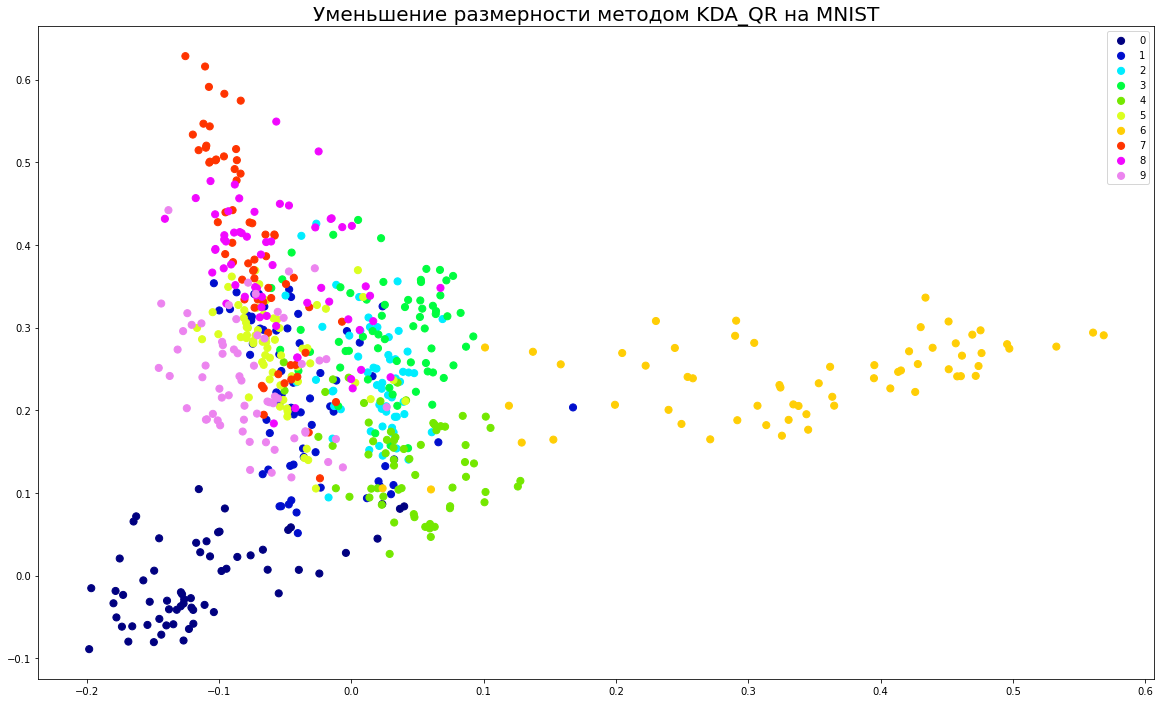

In [ ]:
from matplotlib.colors import Normalize

plt.figure(figsize=(20, 12))
for d in range(10): # перебираем цифру
    norm = Normalize(vmin=0, vmax=10) # для красивых цветов
    
    
    color = plt.cm.gist_ncar(norm(d))
    plt.scatter(X_k_full_show[:, 0][y_test == d],
                X_k_full_show[:, 1][y_test == d],
                c=[color] * len(X_k_full_show[:, 0][y_test == d]), label=d, edgecolor='face', s=50)
plt.title(u"Уменьшение размерности методом KDA_QR на MNIST", fontsize=20)
plt.legend()

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
pre_lda_score = []
lda_qr_score = []
kda_qr_score = []

const = cross_val_score(LogisticRegression(), X, y, scoring='accuracy').mean()
const = [const]*X_l.shape[1]

for i in range(1,X_l.shape[1]+1):
    pre_lda_score.append(cross_val_score(LogisticRegression(), X_l[:,:i], y, scoring='accuracy').mean())
    lda_qr_score.append(cross_val_score(LogisticRegression(), X_l_full[:,:i], y, scoring='accuracy').mean())
    kda_qr_score.append(cross_val_score(LogisticRegression(), X_k_full[:,:i], y_test, scoring='accuracy').mean())

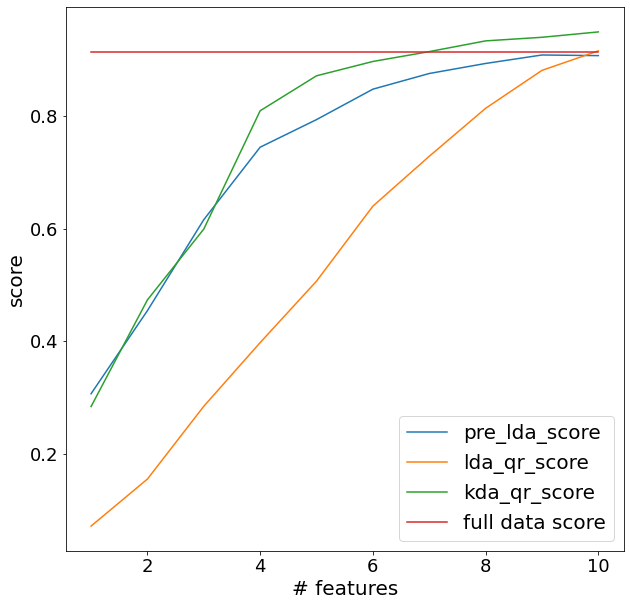

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))



plt.plot(np.arange(1,11), pre_lda_score, label="pre_lda_score")
plt.plot(np.arange(1,11), lda_qr_score, label="lda_qr_score")
plt.plot(np.arange(1,11), kda_qr_score, label="kda_qr_score")
#plt.plot(np.arange(1,11), sk_kda_qr_score, label="sk_kda_qr_score")
plt.plot(np.arange(1,11), const, label="full data score")
plt.legend(fontsize=20)
plt.xlabel("# features", fontsize=20)
plt.ylabel("score", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=1.0)

X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names
cv = sk.model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.45)
for train_index, test_index in cv.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
X.shape

(2370, 11750)

In [ ]:
clf = KdaClassifier(mu=0.1, sigma=23052765)
clf.fit(X, y, num_of_classes=len(np.unique(y)))
X_k_full = clf.transform(X_test)
X_k_full_show = X_k_full[:, :2]
X_k_full.shape

(1067, 34)

In [ ]:
X_l = pre_lda_qr(X,y)
X_l_full = LDA_QR(X,y)

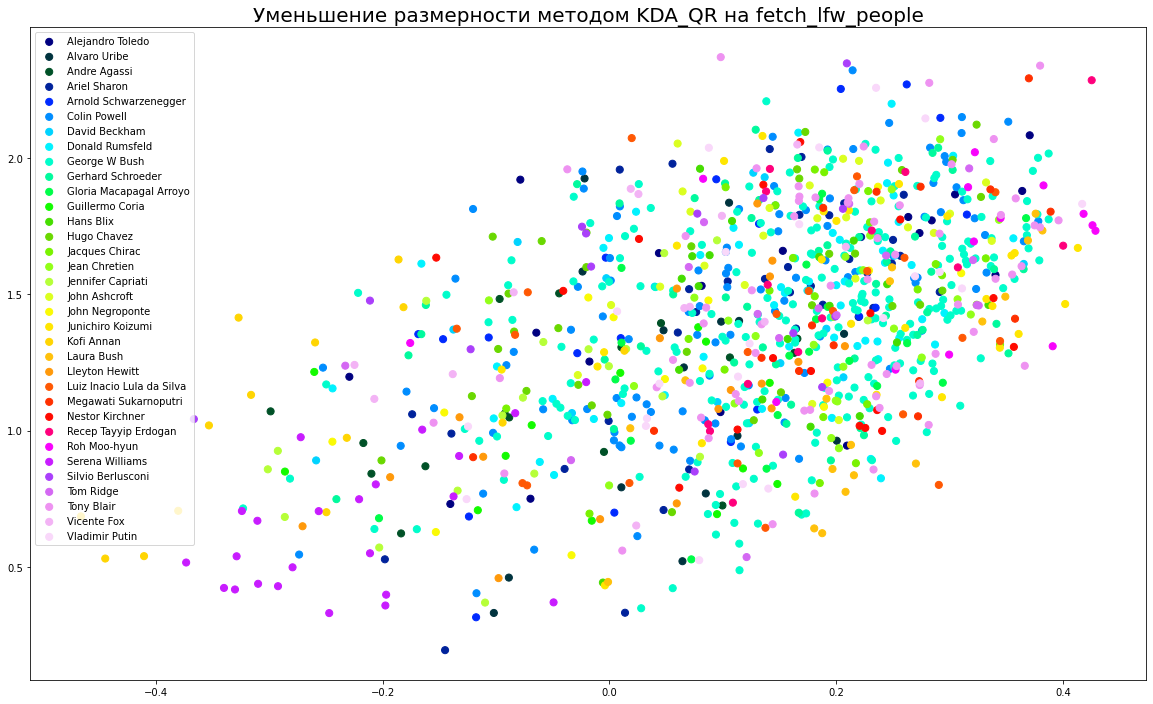

In [ ]:
from matplotlib.colors import Normalize

X_k_full_show = X_k_full[:, :2]

plt.figure(figsize=(20, 12))
for d in range(34): # перебираем цифру
    norm = Normalize(vmin=0, vmax=34) # для красивых цветов
    
    color = plt.cm.gist_ncar(norm(d))
    plt.scatter(X_k_full_show[:, 0][y_test == d],
                X_k_full_show[:, 1][y_test == d],
                c=[color] * len(X_k_full_show[:, 0][y_test == d]), label=names[d], edgecolor='face', s=50)
plt.title(u"Уменьшение размерности методом KDA_QR на fetch_lfw_people", fontsize=20)
plt.legend()

In [ ]:
pre_lda_score = []
lda_qr_score = []
kda_qr_score = []
sk_kda_qr_score = []

for i in range(1,X_l.shape[1]+1, 2):
    pre_lda_score.append(cross_val_score(LogisticRegression(),X_l[:,:i], y, scoring='accuracy').mean())
    lda_qr_score.append(cross_val_score(LogisticRegression(),X_l_full[:,:i], y, scoring='accuracy').mean())
    kda_qr_score.append(cross_val_score(LogisticRegression(), X_k_full[:,:i], y_test, scoring='accuracy').mean())

In [ ]:
const = cross_val_score(LogisticRegression(), X, y, scoring='accuracy').mean()
const = [const]*X_l.shape[1]

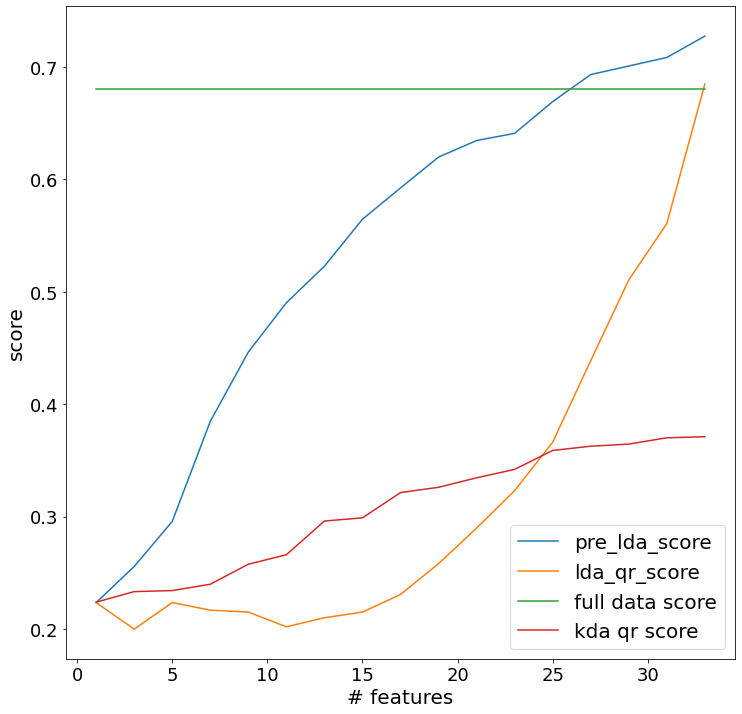

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12))


plt.plot(np.arange(1,35, 2), pre_lda_score, label="pre_lda_score")
plt.plot(np.arange(1,35, 2), lda_qr_score, label="lda_qr_score")
plt.plot(np.arange(1,35, 2), const, label="full data score")
plt.plot(np.arange(1,35, 2), kda_qr_score, label="kda qr score")

plt.legend(fontsize=20)
plt.xlabel("# features", fontsize=20)
plt.ylabel("score", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

plt.show()